In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**<span style="font-size: 24px;">Read and analyse data**

In [3]:
# Read and show our data
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check usefull information such as total entries, cols and dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

From the previous tables we can see that column **diagnosis** is the target label, columns **id** and **Unnamed: 32** are irrelevant for the classification and all the remaining feature columns have different scales.

In [9]:
# Check the diagnosis classes and their distribution
label_distribution = df["diagnosis"].value_counts()
diagnosis_class, class_count = label_distribution["diagnosis"], label_distribution["count"]
label_distribution

KeyError: 'diagnosis'

Since the **diagnosis** classes are slightly unbalanced (357 vs 212) the accuracy metric will not be a good choice to evaluate our model.

**<span style="font-size: 24px;">Data Processing**

In [37]:
# We can drop the "id" and "Unnamed: 32" cols since they do not affect the diagnosis prediction
df.drop(["id", "Unnamed: 32"], axis=1, inplace=True)
print(df.shape)

(569, 31)


In [39]:
# Encode diagnosis to numerical values where M = 1 and B = 0
def diagnosis_encoder(value):
    if value == "M": return 1
    else: return 0
    
df["diagnosis"] = df["diagnosis"].apply(diagnosis_encoder)

diagnosis
0    357
1    212
Name: count, dtype: int64

In [51]:
# Split data into train and test sets
X = df.drop("diagnosis", axis=1).to_numpy()
y = df["diagnosis"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
# Train and evaluate KNeighborsClassifier with different k values using cross-validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors = []
scores = []

for k in range(1, 31, 2):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10, scoring="recall") # 10 folds
    scores.append(score.mean())

Best k value is 7 with recall 0.9294117647058823


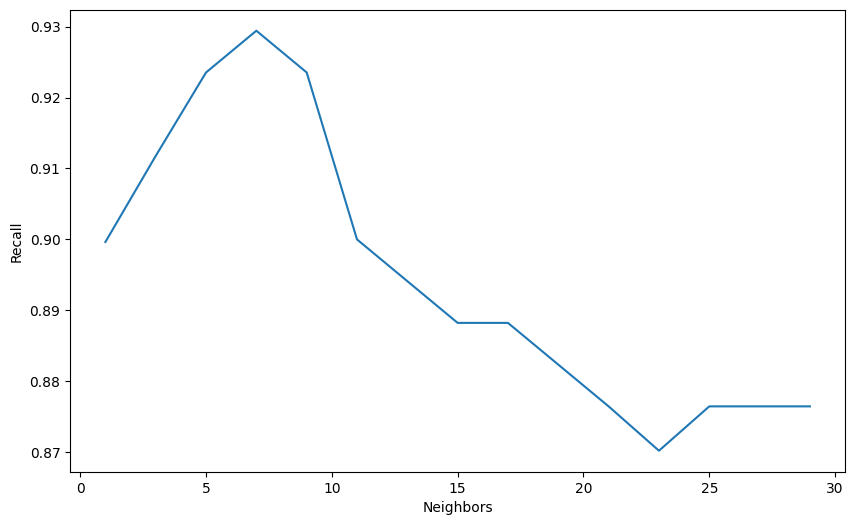

In [97]:
# Find the best k value
best_score_index = scores.index(max(scores))
print(f"Best k value is {neighbors[best_score_index]} with recall {scores[best_score_index]}")

plt.figure(figsize=(10, 6))
plt.plot(neighbors, scores)
plt.xlabel("Neighbors")
plt.ylabel("Recall")
plt.show()

In [102]:
# Evaluate model with k=7 using classification report
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=neighbors[best_score_index])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"])
print(report)

              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        71
   Malignant       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [ ]:
#TODO PCA